### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import multiprocessing
import re # for regular expressions
import pandas as pd  
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Analysis

In [2]:
Train = pd.read_csv("Corona_NLP_train.csv")
Test = pd.read_csv("Corona_NLP_test.csv")

In [3]:
df=Test.append(Train, ignore_index=True)

In [4]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
44950,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44951,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44952,44953,89905,NaN,14-04-2020,You know itÂ’s getting tough when @KameronWild...,Positive
44953,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In [6]:
df.shape

(44955, 6)

#### Column Names

In [7]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [8]:
un=df.OriginalTweet.value_counts()

In [9]:
un.shape

(44955,)

### Converting 5 class to 2 class

In [10]:
y=df['Sentiment']

In [11]:
Y=[]
for i in y:
    if i=='Positive' or i=="Extremely Positive" or i=='Neutral':
        Y.append('Positive')
    else: 
        Y.append('Negative')

In [12]:
Y=pd.DataFrame(Y)
Y.columns=['Sentiment']

In [13]:
df['2Sentiment']=Y

In [14]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,2Sentiment
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive,Positive
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,Positive
...,...,...,...,...,...,...,...
44950,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,Positive
44951,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,Negative
44952,44953,89905,NaN,14-04-2020,You know itÂ’s getting tough when @KameronWild...,Positive,Positive
44953,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,Positive


In [15]:
df=df.drop(labels='Sentiment',axis=1)
df= df.rename(columns={'2Sentiment' : 'Sentiment'})

In [16]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Negative' 'Positive']
Positive    27924
Negative    17031
Name: Sentiment, dtype: int64


In [17]:
class_df = df.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='coolwarm')

,Sentiment,OriginalTweet
1,Positive,27924
0,Negative,17031


### Data Visualisation
#### 1. Distribution of Positive & Negative Tweets

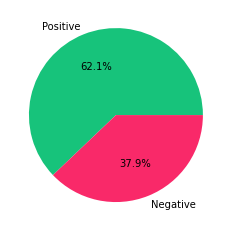

In [18]:
subjects= "Positive", "Negative"
weightage= [27924, 17031]

plt.pie(weightage, labels= subjects, colors=['#17C37B','#F92969'],autopct= '%1.1f%%')

plt. show()

#### 2. Percentage of Missing Values

In [19]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns
missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

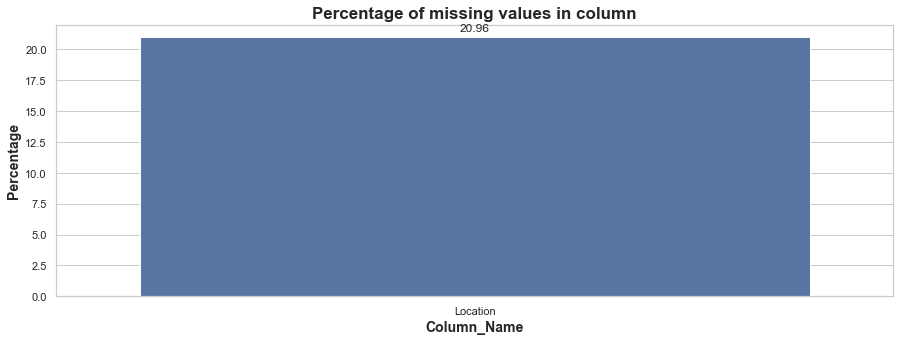

In [20]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

#### 3. Number of Unique Values in each Column

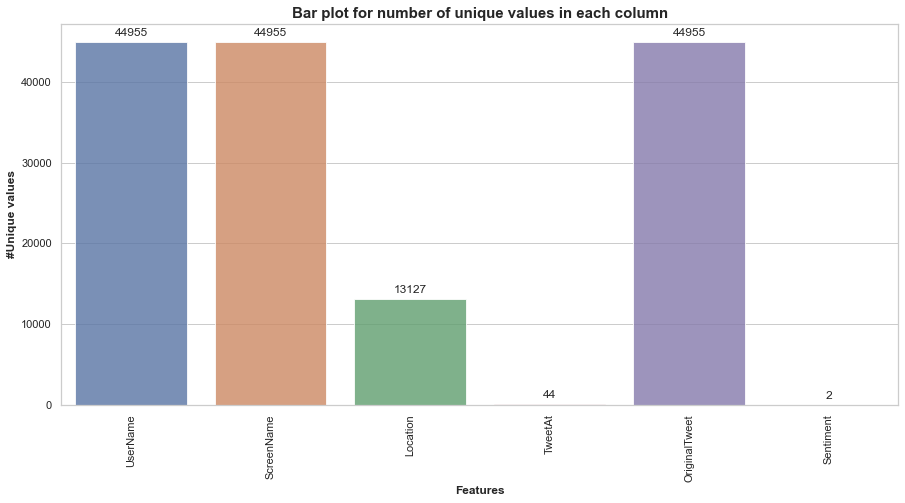

In [21]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

#### -Understanding Hashtags

In [22]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [23]:
# extracting hashtags from non racist/sexist tweets
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])

# unnesting list
HT_Positive = sum(HT_Positive, [])
HT_Negative = sum(HT_Negative,[])

#### 4.  Frequency Distribution top 10 Positive hashtags

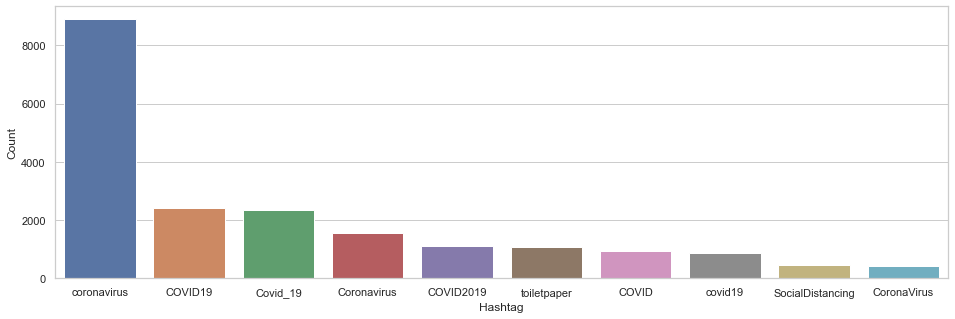

In [24]:
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

#### 5. Frequency Distribution top 10 Negative hashtags

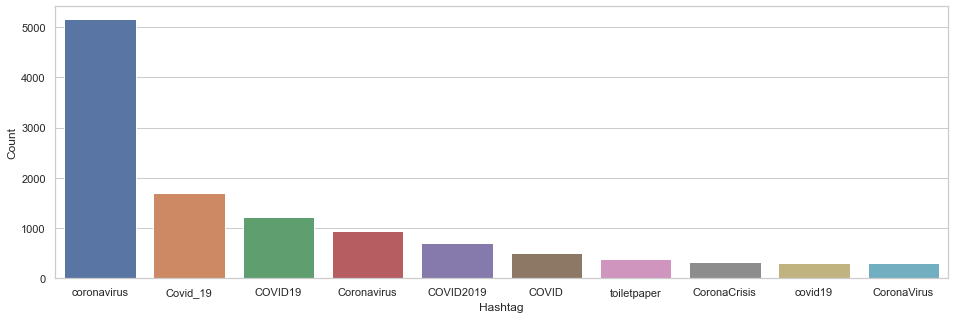

In [25]:
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

## Preprocessing


#### 1. Remove @user

In [26]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [28]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [29]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Negative,TRENDING: New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Positive,Find out how you can protect yourself and love...


#### 2. Remove https and urls

In [30]:
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [31]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Negative,TRENDING: New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...


In [32]:
df.shape

(44955, 7)

#### 3. Remove special characters, numbers, punctuations

In [33]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

#### 4. Remove Short Words

In [34]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

#### 5. Tokenization

In [35]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

#### 6. Stemming

In [36]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [37]:
tokenized_tweet= tokenized_tweet.to_frame()

In [38]:
tokenized_tweet=tokenized_tweet.values

In [39]:
len(tokenized_tweet)

44955

In [40]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i][0] = ' '.join(tokenized_tweet[i][0])
    
# change df['Tweet'] to tokenized_tweet

In [41]:
tokenized_tweet.shape


(44955, 1)

In [42]:
df['Tweet']  = tokenized_tweet

In [43]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Negative,trend new yorker encount empti supermarket she...
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,when couldn find hand sanit fred meyer turn #a...
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Positive,find out how you can protect yourself and love...
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative,#panic buy hit #newyork citi anxiou shopper st...
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Positive,#toiletpap #dunnypap #coronaviru #coronavirusa...


## Creating Wordcloud

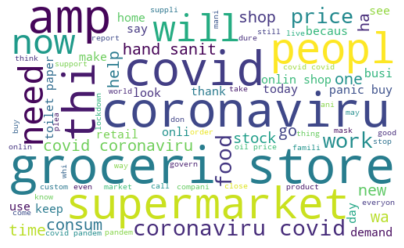

In [44]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=500, height=300, background_color='white',random_state=21, max_font_size=80, min_font_size=10).generate(all_words)

plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [45]:
def create_blank_black_canvas(width, height):
    image = np.zeros((height, width, 3), np.uint8)
    return image

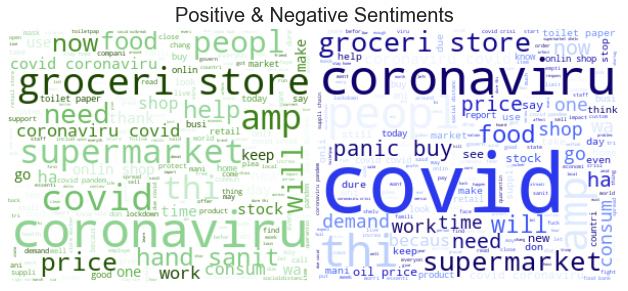

In [50]:

canvas = create_blank_black_canvas(600, 250)
# create text from just normal tweets

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])
wordcloud1 = WordCloud(width=300, height=250, random_state=21, max_font_size=80, background_color='white',colormap='Greens').generate(normal_words)

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])
wordcloud2 = WordCloud(width=300, height=250, random_state=21, max_font_size=80,background_color='white',colormap='Reds').generate(normal_words)

wordcloud1.to_file("wordCloud1.png")
wordcloud2.to_file("wordCloud2.png")

tl = cv2.imread('wordCloud1.png')
tr = cv2.imread('wordCloud2.png')

canvas[0:250, 0:300] = tl
canvas[0:250, 300:600] = tr

plt.figure(figsize=(11,9))
plt.imshow(canvas,interpolation="bilinear")
plt.title("Positive & Negative Sentiments", fontsize=20)
plt.axis('off')
plt.show()

### Extracting features from cleaned tweets

In [51]:
new_df = df[['Tweet']]
y= df[['Sentiment']]
y=y.values

In [52]:
Y=[]
for i in y:
    if i== 'Negative':
        Y.append(0)
    else:
        Y.append(1)

y=pd.DataFrame(Y)
new_df['Sentiment']=y   

In [53]:
new_df

,Tweet,Sentiment
0,trend new yorker encount empti supermarket she...,0
1,when couldn find hand sanit fred meyer turn #a...,1
2,find out how you can protect yourself and love...,1
3,#panic buy hit #newyork citi anxiou shopper st...,0
4,#toiletpap #dunnypap #coronaviru #coronavirusa...,1
...,...,...
44950,airlin pilot offer stock supermarket shelv #nz...,1
44951,respons complaint not provid cite covid relat ...,0
44952,you know get tough when ration toilet paper #c...,1
44953,wrong that the smell hand sanit start turn #co...,1


In [54]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [56]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0        [r, e, n,  , n, e, w,  , r, k, e, r,  , e, n, ...
1        [w, h, e, n,  , c, u, l, n,  , f, n,  , h, n, ...
2        [f, n,  , u,  , h, w,  , u,  , c, n,  , p, r, ...
3        [#, p, n, c,  , b, u,  , h,  , #, n, e, w, r, ...
4        [#, l, e, p, p,  , #, u, n, n, p, p,  , #, c, ...
                               ...                        
44950    [r, l, n,  , p, l,  , f, f, e, r,  , c, k,  , ...
44951    [r, e, p, n,  , c, p, l, n,  , n,  , p, r, v, ...
44952    [u,  , k, n, w,  , g, e,  , u, g, h,  , w, h, ...
44953    [w, r, n, g,  , h,  , h, e,  , e, l, l,  , h, ...
44954    [w, e, l, l,  , n, e, w,  , u, e,  , r, f,  , ...
Name: Tweet, Length: 44955, dtype: object

## Train-Test Split

In [57]:
from sklearn.model_selection import train_test_split
train,valid = train_test_split(new_df,test_size = 0.2,random_state=100,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
X=pd.DataFrame(new_df['Tweet'])
y=pd.DataFrame(new_df['Sentiment'])

print("X shape : ", X.shape)
print("y shape : ", y.shape)
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

X shape :  (44955, 1)
y shape :  (44955, 1)
train shape :  (35964, 2)
valid shape :  (8991, 2)


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)
X= vectorizer.fit_transform(X.Tweet.values)

Y_train = train.Sentiment.values
Y_valid = valid.Sentiment.values
y= y.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", Y_train.shape)
print("y_valid.shape : ", Y_valid.shape)

X_train.shape :  (35964, 28355)
X_train.shape :  (8991, 28355)
y_train.shape :  (35964,)
y_valid.shape :  (8991,)


## Models
### Logistic Regression

In [59]:
logreg = LogisticRegression(solver='liblinear', C=0.5)

logreg.fit(X_train, Y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(Y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,Y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print("\nClassification Report : \n", classification_report(logreg_prediction,Y_valid)) 
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, logreg_prediction))

Training accuracy Score    :  0.9200033366700033
Testing accuracy Score :  0.8595261928595261

Classification Report : 
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      3041
           1       0.92      0.86      0.89      5950

    accuracy                           0.86      8991
   macro avg       0.84      0.86      0.85      8991
weighted avg       0.87      0.86      0.86      8991


Confusion Matrix : 
 [[2592  814]
 [ 449 5136]]


#### Accuracy using 5 fold cross validation:

In [60]:
logreg.fit(X, Y)
cross_val_score(logreg, X, Y, scoring="accuracy", cv=5).mean()

0.8497163830497163

### Multinomial Naive Bayes

In [61]:
mnb = MultinomialNB(alpha=2)

# Training 
mnb.fit(X_train,Y_train)

#Predictions
pred=mnb.predict(X_valid)

mnb_accuracy = accuracy_score(Y_valid,pred)
print("Training accuracy Score    : ", mnb.score(X_train,Y_train))
print("Testing accuracy Score : ", mnb_accuracy )
print("\nClassification Report : \n", classification_report(pred,Y_valid)) 
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, pred))

Training accuracy Score    :  0.8440940940940941
Testing accuracy Score :  0.7876765654543433

Classification Report : 
               precision    recall  f1-score   support

           0       0.65      0.76      0.70      2925
           1       0.87      0.80      0.84      6066

    accuracy                           0.79      8991
   macro avg       0.76      0.78      0.77      8991
weighted avg       0.80      0.79      0.79      8991


Confusion Matrix : 
 [[2211 1195]
 [ 714 4871]]


### Decision Tree

In [62]:
dtc = DecisionTreeClassifier(criterion='gini',max_depth=20)
dtc.fit(X_train, Y_train)
dtc_prediction = dtc.predict(X_valid)
dtc_accuracy = accuracy_score(Y_valid,dtc_prediction)

print("Training accuracy Score    : ",dtc.score(X_train,Y_train))
print("Testing accuracy Score : ",dtc_accuracy )
print("\nClassification Report : \n", classification_report(dtc_prediction,Y_valid))
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, dtc_prediction))

Training accuracy Score    :  0.7922644867089311
Testing accuracy Score :  0.7519741964186408

Classification Report : 
               precision    recall  f1-score   support

           0       0.50      0.76      0.61      2246
           1       0.90      0.75      0.82      6745

    accuracy                           0.75      8991
   macro avg       0.70      0.76      0.71      8991
weighted avg       0.80      0.75      0.77      8991


Confusion Matrix : 
 [[1711 1695]
 [ 535 5050]]


### SVM
- Grid Search to find the best parameters for SVM

In [65]:
params = [
    {
        'kernel':['linear','rbf','poly','sigmoid'],
        'C':[0.1,0.2,0.5,1.0,2.0,5.0]
    }   
]
cpus = multiprocessing.cpu_count()
gs = GridSearchCV(estimator=svm.SVC(),param_grid=params,scoring="accuracy",cv=5,n_jobs = cpus)

In [66]:
gs.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=12,
             param_grid=[{'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0],
                          'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}],
             scoring='accuracy')

In [67]:
gs.best_estimator_

SVC(C=0.2, kernel='linear')

In [68]:
gs.best_score_

0.8513513284683679

#### Therefore linear SVM with C=0.2 is the best model for our classification, with acc = 85.13%

In [70]:
svm= svm.SVC(C=0.2, kernel='linear')
# Training 
svm.fit(X_train,Y_train)

#Predictions
svm_pred=svm.predict(X_valid)

svm_accuracy = accuracy_score(Y_valid,svm_pred)
print("Training accuracy Score    : ", svm.score(X_train,Y_train))
print("Testing accuracy Score : ", svm_accuracy )
print("\nClassification Report : \n", classification_report(svm_pred,Y_valid)) 
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, svm_pred))

Training accuracy Score    :  0.9229785340896453
Testing accuracy Score :  0.8577466355244133

Classification Report : 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80      3089
           1       0.91      0.86      0.89      5902

    accuracy                           0.86      8991
   macro avg       0.84      0.85      0.85      8991
weighted avg       0.86      0.86      0.86      8991


Confusion Matrix : 
 [[2608  798]
 [ 481 5104]]


### Multi-Layer Perceptron

In [73]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [74]:
mlp.fit(X_train,Y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [79]:
mlp_pred=mlp.predict(X_valid)
mlp_accuracy = accuracy_score(Y_valid,mlp_pred)
print("Accuracy Score : ", mlp_accuracy )
print("\nClassification Report : \n", classification_report(mlp_pred,Y_valid))
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, mlp_pred))

Accuracy Score :  0.8548548548548549

Classification Report : 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80      3169
           1       0.90      0.87      0.89      5822

    accuracy                           0.85      8991
   macro avg       0.84      0.85      0.84      8991
weighted avg       0.86      0.85      0.86      8991


Confusion Matrix : 
 [[2635  771]
 [ 534 5051]]


In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,150), learning_rate='adaptive', max_iter=500)

## Ensemble Model

In [71]:
ensemble= VotingClassifier(estimators=[ ('LR', logreg), ('SVM', svm)], voting='hard', weights=[1,1])

In [72]:
ensemble.fit(X_train, Y_train)
ensemble_pred = ensemble.predict(X_valid)

ensemble_accuracy = accuracy_score(Y_valid,ensemble_pred)
print("Training accuracy Score : ",ensemble.score(X_train,Y_train))
print("Testing accuracy Score : ",ensemble_accuracy )
print("\nClassification Report : \n", classification_report(ensemble_pred,Y_valid))
print("\nConfusion Matrix : \n", confusion_matrix(Y_valid, pred))

Training accuracy Score :  0.9246190635079524
Testing accuracy Score :  0.8599710821933044

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      3209
           1       0.90      0.87      0.89      5782

    accuracy                           0.86      8991
   macro avg       0.85      0.85      0.85      8991
weighted avg       0.86      0.86      0.86      8991


Confusion Matrix : 
 [[2211 1195]
 [ 714 4871]]


In [78]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes', 'Decision Tree',
              'Support Vector Machines', 'Multi-Layer Perceptron', 'Ensemble Model'
              ],
    'Test accuracy': [logreg_accuracy, mnb_accuracy, dtc_accuracy, svm_accuracy,  
              mlp_accuracy, ensemble_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
5,Ensemble Model,0.859971
0,Logistic Regression,0.859526
3,Support Vector Machines,0.857747
4,Multi-Layer Perceptron,0.854855
1,Multinomial Naive Bayes,0.787677
2,Decision Tree,0.751974
